In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import pdb


from itertools import zip_longest, product, chain
import random
from pathlib import Path
import torch
import torch.nn as nn
from torchvision.transforms.functional import (pad, to_tensor, to_pil_image, normalize,
                                               hflip, vflip, crop)

torch.manual_seed(0);

from PIL import Image
from IPython.display import display

In [2]:
from torchvision import models
import torch.nn as nn


def make_decoder_block(in_channels, middle_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, middle_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(
            middle_channels, out_channels, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True))


class UNet(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        if pretrained:
            encoder = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1).features
        else:
            encoder = models.vgg16_bn(weights=None).features

        self.conv1 = encoder[:6]
        self.conv2 = encoder[6:13]
        self.conv3 = encoder[13:23]
        self.conv4 = encoder[23:33]
        self.conv5 = encoder[33:43]

        self.center = nn.Sequential(
            encoder[43],  # MaxPool
            make_decoder_block(512, 512, 256))

        self.dec5 = make_decoder_block(256 + 512, 512, 256)
        self.dec4 = make_decoder_block(256 + 512, 512, 256)
        self.dec3 = make_decoder_block(256 + 256, 256, 64)
        self.dec2 = make_decoder_block(64 + 128, 128, 32)
        self.dec1 = nn.Sequential(
            nn.Conv2d(32 + 64, 32, 3, padding=1), nn.ReLU(inplace=True))
        self.final = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        center = self.center(conv5)

        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))

        return self.final(dec1)

In [86]:
def calculate_bboxes(im_shape, patch_size):
    h, w = im_shape  # 640,1080
    ph, pw = patch_size  # 256,256
    # range(0, h - ph, ph)=0부터 1080-256=824까지 256간격으로 값 생성
    steps_h = chain(range(0, h - ph, ph), [h - ph]) 
    steps_w = chain(range(0, w - pw, pw), [w - pw])

    return product(steps_h, steps_w)


class Image2Patches():
    '''큰 이미지 받아 작은 여러개의 patch로 분할해 줌'''
    def __init__(self, image_size = (1080,640), patch_size=(256, 256), padding=16):
        self.image_size = image_size
        self.patch_size = patch_size
        self.padding = padding
        self.patch_size_expanded = (patch_size[0] + 2 * padding,
                                    patch_size[1] + 2 * padding)

        w, h = self.image_size
        bboxes = calculate_bboxes((h, w), self.patch_size)
        self.coords = list(zip_longest([], bboxes, fillvalue=0))
        print(self.coords)
        
    def __call__(self, image):
        patches = []
        for idx in range(len(self.coords)):
            cell = image.copy()
            _, (i, j) = self.coords[idx]   
            h, w = self.patch_size_expanded   

            cell = pad(cell, self.padding, padding_mode='reflect')
            cell = crop(cell, i, j, h, w)
            cell = to_tensor(cell)  
            cell = normalize(cell, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            patches.append((cell, (i,j)))

        return patches
    

def strength_line3(image, mask_im, rho, theta, thickness=2, imsize=(256,256)):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))  # c
    y1 = int(y0 + 1000 * (a))  # r
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), thickness)

    # 선 위의 모든 픽셀 좌표 계산
    all_line_pixels = []
    for t in np.linspace(0, 1, max(abs(x2 - x1), abs(y2 - y1))):
        x = int(x1 * (1 - t) + x2 * t)  # c
        y = int(y1 * (1 - t) + y2 * t)  # r
        if 0 < x < imsize[1] and 0 < y < imsize[0]:
            all_line_pixels.append((x, y))  #(c,r)
            
    total_sum = sum(mask_im[r,c] for c,r in all_line_pixels)/len(all_line_pixels)  # mask[r,c]
    
    return image, total_sum, all_line_pixels

    
def select_bestline(lines, src_image, pred_mask):
    votes = []
    if lines is not None:
        for idx, (rho, theta) in enumerate(lines[:, 0]):
            res_im, psum, all_line_pixels = strength_line3(src_image.copy(), pred_mask, rho, theta)
            votes.append((res_im, psum, all_line_pixels, (rho,theta)))

        max_element = max(votes, key=lambda x: x[1])
        return max_element

    return None
    
    
def convert_cell_to_img(t, padding=16):
    """Converts pytorch tensor into a Pillow Image. The padding will be removed
    from the resulting image"""
    std = torch.Tensor([0.229, 0.224, 0.225]).reshape(-1, 1, 1)
    mu = torch.Tensor([0.485, 0.456, 0.406]).reshape(-1, 1, 1)
    output = t.mul(std)
    output.add_(mu)
    img = to_pil_image(output)
    w, h = img.size
    return img.crop((padding, padding, w - padding, h - padding))
    
    
class LineDetector():
    def __init__(self, mask_thres = 0.7,
                 blur_wsize=5, blur_sigma=1.4, 
                 canny_low_thres=30, canny_hight_thres=80, 
                 hough_min_length=50, padding=16):
        self.mask_thres = mask_thres
        self.wsize = blur_wsize
        self.sigma = blur_sigma
        self.low_thres = canny_low_thres
        self.high_thres = canny_hight_thres
        self.min_length = hough_min_length
        
    def __call__(self, org_image, pred_mask, padding=16):
        if isinstance(org_image, torch.Tensor):
            org_image = convert_cell_to_img(org_image, padding=padding)
        image = np.array(org_image)  # numpy image

        blurred_image = cv2.GaussianBlur(image, (self.wsize, self.wsize), self.sigma)
        edges = cv2.Canny(blurred_image, self.low_thres, self.high_thres)

        result_image = np.where(pred_mask >= self.mask_thres, edges, 0)  
        lines = cv2.HoughLines(result_image, 1, np.pi / 180, self.min_length)

        return lines, image        

In [87]:
image_path = os.path.join('data','image','frame_0041_part_1_time_19.13.jpg')
image = Image.open(image_path)

print(image.format, image.size, image.mode)  
#display(image)

JPEG (1080, 640) RGB


In [145]:
class GasDoor(nn.Module):
    def __init__(self, pt_fname='best_params_0011.pt'):
        super().__init__()
        self.im2patch = Image2Patches(image_size = (1080,640), patch_size=(256, 256))
        self.line_detector = LineDetector(mask_thres = 0.7, hough_min_length=200)

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = UNet(pretrained=True).to(self.device)
        self.model.load_state_dict(torch.load(pt_fname))       
        
    def predict_with_model(self, patches):
        predictions = []
        self.model.eval()
        with torch.no_grad():  
            for patch, (i, j) in patches:
                patch = patch.unsqueeze(0)  
                patch = patch.to(self.device)
                mask = self.model(patch).squeeze()
                mask = mask.cpu().detach().numpy()
                prob_mask = 1/(1 + np.exp(-mask))
                predictions.append((prob_mask, (i, j)))
        return predictions
    
    def combine_patches(self, predictions, image_size, padding):
        combined_image = np.zeros((image_size[0], image_size[1]), dtype=np.uint8)  #(640,1080)
        for patch, (i, j) in predictions:
            patch_img = patch[padding:-padding, padding:-padding]
            patch_img = (patch_img * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8
            h, w = patch_img.shape
            combined_image[i:i+h, j:j+w] = patch_img
        return combined_image    
    
    def detect_lines(self, patches, predictions, padding):
        all_lines = []
        for idx, ((patch, (i, j)), (mask, (m, n))) in enumerate(zip(patches, predictions)):
            mask_img = mask[padding:-padding, padding:-padding]  # Remove mask padding
            lines, src_image = self.line_detector(patch, mask_img)
            max_element = select_bestline(lines, src_image, mask_img)
            if max_element:
                res_im_max, psum_max, all_line_pixels, (rho,theta) = max_element
                all_lines.append((all_line_pixels, (i,j), (rho,theta)))
                print(f"{idx}: Maximum psum: {psum_max}, Number of pixels on line: {len(all_line_pixels)}") 
                
        return all_lines
    
    def extract_hough(self, image, mask, padding):
        all_lines = []
        lines, src_image = self.line_detector(image, mask, padding=padding)
        for (rho,theta) in lines[:,0,:]:
            #pdb.set_trace()
            if rho<0:  ##########################
                rho = -rho
                theta = theta+np.pi
            all_lines.append((rho,theta))
#             max_element = select_bestline(lines, src_image, mask_img)
#             if max_element:
#                 res_im_max, psum_max, all_line_pixels, (rho,theta) = max_element
#                 all_lines.append((all_line_pixels, (rho,theta)))
#                 print(f"{idx}: Maximum psum: {psum_max}, Number of pixels on line: {len(all_line_pixels)}") 
                
        return all_lines    
        
    def convert_new_hough(self, all_lines):
        def convert_rho_theta(r, c, rho, theta):
            theta_rad = theta  # 이미 라디안 단위로 제공된 경우
            new_rho = rho + c * np.cos(theta_rad) + r * np.sin(theta_rad)
            if new_rho<0:  ##########################
                new_rho = -new_rho
                theta = theta+np.pi
            return new_rho, theta    
        return [convert_rho_theta(r,c,rho,theta) for _, (r,c),(rho,theta) in all_lines]
    
    def predict(self, image, padding=16):
        patches = self.im2patch(image)  # split image to patches
        predictions = self.predict_with_model(patches)  # predict masks
        combined_mask = self.combine_patches(predictions, (640,1080), 16)  # combine masks
#         all_lines = self.extract_hough(image, combined_mask, padding=0)
#         pdb.set_trace()

#         padding = padding
#         all_lines = self.detect_lines(patches, predictions, padding)
#         new_hough = self.convert_new_hough(all_lines)
#         print(new_hough)
        
        return combined_mask, patches, predictions
        
        
gas_door = GasDoor()

[(0, (0, 0)), (0, (0, 256)), (0, (0, 512)), (0, (0, 768)), (0, (0, 824)), (0, (256, 0)), (0, (256, 256)), (0, (256, 512)), (0, (256, 768)), (0, (256, 824)), (0, (384, 0)), (0, (384, 256)), (0, (384, 512)), (0, (384, 768)), (0, (384, 824))]


In [146]:
#patches, predictions = gas_door.predict(image)
mask, patches, predictions = gas_door.predict(image)

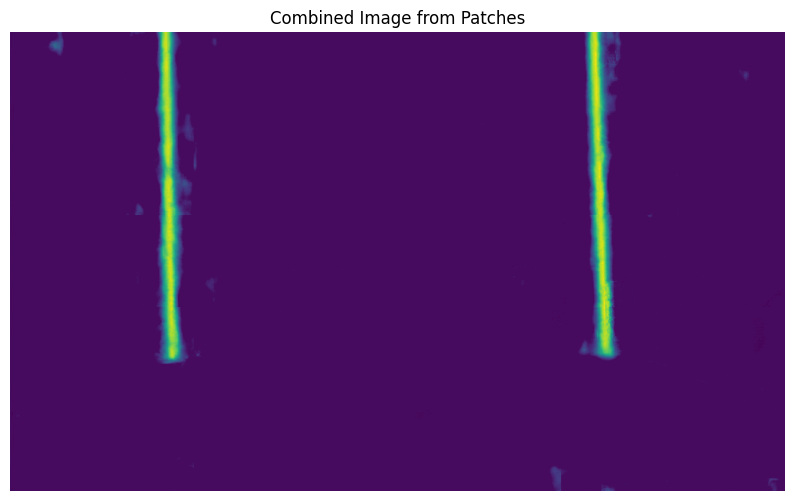

In [147]:
plt.figure(figsize=(10, 10))
plt.imshow(mask)
plt.title("Combined Image from Patches")
plt.axis('off')
plt.show()

In [148]:
type(mask), mask.shape

(numpy.ndarray, (640, 1080))

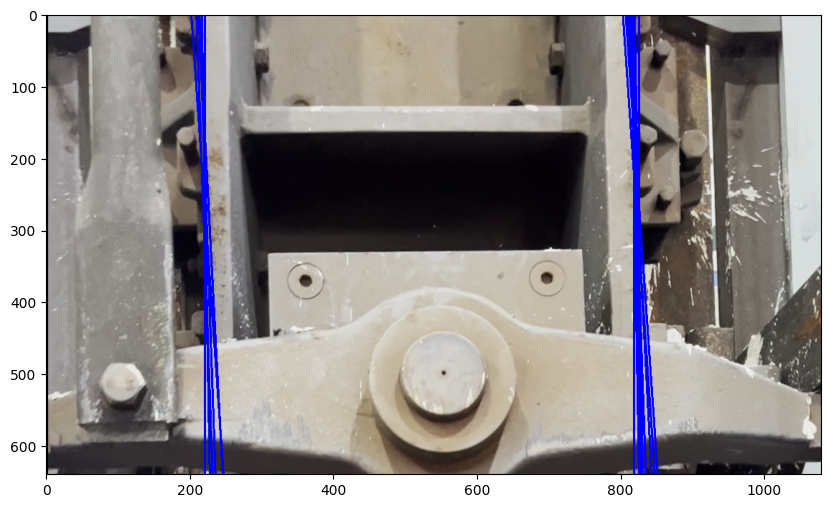

(15,
 numpy.ndarray,
 [(217.0, 6.2657319625192365),
  (813.0, 6.248278768854686),
  (820.0, 6.2657319625192365),
  (214.0, 6.248278768854686),
  (809.0, 6.230825336771556),
  (826.0, 0.0),
  (210.0, 6.248278768854686),
  (815.0, 6.2657319625192365),
  (221.0, 0.0),
  (212.0, 6.230825336771556),
  (818.0, 6.2657319625192365),
  (806.0, 6.213372143107005),
  (819.0, 0.0),
  (202.0, 6.213372143107005),
  (802.0, 6.213372143107005)])

In [91]:
def points_on_line2(org_img, pred_mask, mask_thres=150, \
                   wsize=5, sigma=1.4, low_thres=30, high_thres=80, min_length=50):
    padding = 0
    if isinstance(org_img, torch.Tensor):
        org_img = convert_cell_to_img(org_img, padding=padding)
    image = np.array(org_img)
    
    # 가우시안 블러를 사용하여 노이즈 감소
    blurred_image = cv2.GaussianBlur(image, (wsize, wsize), sigma)
    # Canny 에지 검출
    edges = cv2.Canny(blurred_image, low_thres, high_thres)

    result_image = np.where(pred_mask >= mask_thres, edges, 0)  
    lines = cv2.HoughLines(result_image, 1, np.pi / 180, min_length)
    
    all_lines = []
    for (rho,theta) in lines[:,0]:
        if rho<0:  
            rho = -rho
            theta = theta+np.pi
        all_lines.append((rho,theta))    
    return all_lines


def strength_line2(image, mask_im, rho, theta, thickness=2, imsize=(256,256)):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), thickness)

#     # 선 위의 모든 픽셀 좌표 계산
#     all_line_pixels = []
#     for t in np.linspace(0, 1, max(abs(x2 - x1), abs(y2 - y1))):
#         x = int(x1 * (1 - t) + x2 * t)
#         y = int(y1 * (1 - t) + y2 * t)
#         if 0 < x < imsize[0] and 0 < y < imsize[1]:
#             all_line_pixels.append((x, y))
            
#     total_sum = sum(mask_im[y, x] for x, y in all_line_pixels)
    
#     return image, total_sum, all_line_pixels
    return image

    
def select_bestline2(lines, src_image, pred_mask):
    if lines is not None:
        img = np.array(src_image.copy())
        for idx, (rho, theta) in enumerate(lines):
            #res_im, psum, all_line_pixels = strength_line(src_image.copy(), pred_mask, rho, theta, imsize=(640,1080))
            img = strength_line2(img, pred_mask, rho, theta, imsize=(640,1080))
        return img

    return None




lines = points_on_line2(image, mask, min_length=70)
img =  select_bestline2(lines, image, mask)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

len(lines), type(img), lines

In [111]:
data = np.array(lines)
data.shape, mask.shape

((15, 2), (640, 1080))

In [112]:
def dbscan_line(data, eps=10, min_samples=2):
    rho, theta_deg = data[:, 0], data[:,1]
    theta_rad = np.deg2rad(theta_deg)

    # 새로운 데이터셋 (rho, sin(theta), cos(theta))
    sin_theta = np.sin(theta_rad)
    cos_theta = np.cos(theta_rad)
    transformed_data = np.column_stack((rho, sin_theta, cos_theta))

    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(transformed_data)

    labels = dbscan.labels_
    unique_labels = set(labels)
    indexes = [np.where(labels == ind)[0] for ind in unique_labels]
    
    return indexes, labels, unique_labels


indexes, labels, unique_labels = dbscan_line(data)
indexes, labels, unique_labels

([array([ 0,  3,  6,  8,  9, 13], dtype=int64),
  array([ 1,  2,  4,  5,  7, 10, 11, 12, 14], dtype=int64)],
 array([0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1], dtype=int64),
 {0, 1})

In [126]:
def strength_line3(image, mask_im, rho, theta, thickness=2, imsize=(256,256)):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))  # c
    y1 = int(y0 + 1000 * (a))  # r
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), thickness)

    # 선 위의 모든 픽셀 좌표 계산
    all_line_pixels = []
    for t in np.linspace(0, 1, max(abs(x2 - x1), abs(y2 - y1))):
        x = int(x1 * (1 - t) + x2 * t)  # c
        y = int(y1 * (1 - t) + y2 * t)  # r
        if 0 < x < imsize[1] and 0 < y < imsize[0]: 
            all_line_pixels.append((x, y))  #(c,r)
            
    total_sum = sum(mask_im[r,c] for c,r in all_line_pixels)/len(all_line_pixels)  # mask[r,c]
    
    return image, total_sum, all_line_pixels

In [127]:
image.size, mask.shape

((1080, 640), (640, 1080))

In [149]:
def best_hough(data, indexes, image, mask):
    best_lines = []
    for indx in indexes:
        votes = []
        for idx, (rho, theta) in enumerate(data[indx]):
            img = np.array(image.copy())
            res_im, psum, all_line_pixels = strength_line3(img, mask, rho, theta, imsize=(640,1080))
            votes.append((res_im, psum, all_line_pixels, (rho,theta)))

        max_element = max(votes, key=lambda x: x[1])    
        best_lines.append(max_element)
        
    return best_lines


best_lines = best_hough(data, indexes, image, mask)
for max_element in best_lines:
    res_im_max, psum_max, all_line_pixels, (rho,theta) = max_element
    print(max_element[-1])

(217.0, 6.2657319625192365)
(813.0, 6.248278768854686)


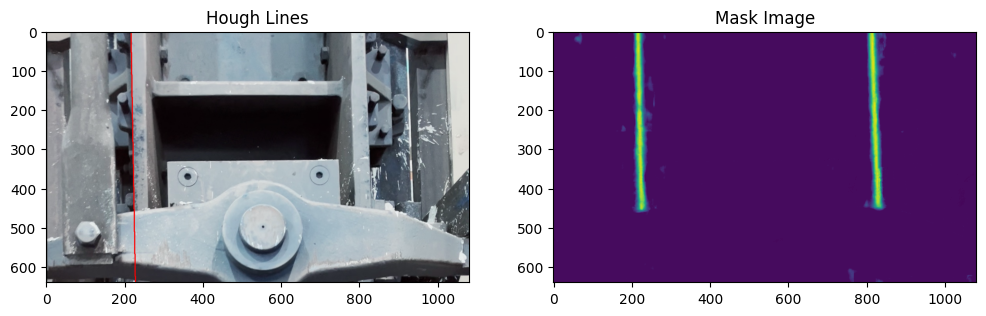

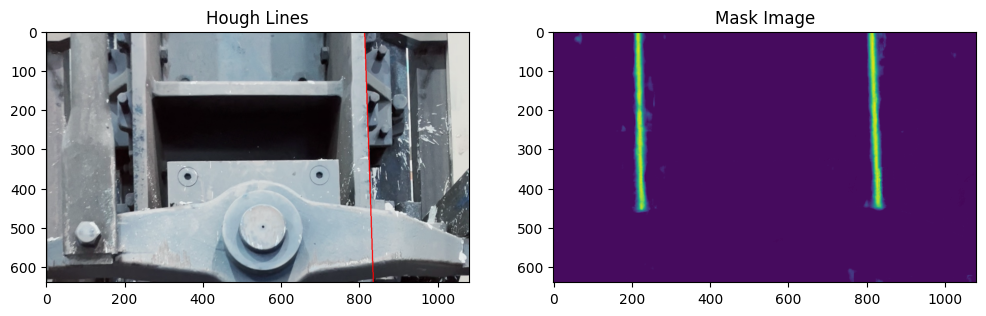

In [138]:
for indx in indexes:
    votes = []
    for idx, (rho, theta) in enumerate(data[indx]):
        img = np.array(image.copy())
        res_im, psum, all_line_pixels = strength_line3(img, mask, rho, theta, imsize=(640,1080))
        votes.append((res_im, psum, all_line_pixels, (rho,theta)))
        #print(rho, theta, psum, len(all_line_pixels))
        
    max_element = max(votes, key=lambda x: x[1])    
    res_im_max, psum_max, all_line_pixels, (rho,theta) = max_element
    # 이미지 표시
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(res_im_max, cv2.COLOR_BGR2RGB))
    plt.title('Hough Lines')
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title('Mask Image')

    plt.show() 

In [29]:
from sklearn.cluster import KMeans

data = np.array(lines)

# theta 값을 라디안으로 변환하고, 이를 사인 및 코사인 값으로 변환
rho = data[:, 0]
theta_deg = data[:, 1]
theta_rad = np.deg2rad(theta_deg)

# 사인 및 코사인 값 계산
sin_theta = np.sin(theta_rad)
cos_theta = np.cos(theta_rad)

# 새로운 데이터셋 (rho, sin(theta), cos(theta))
transformed_data = np.column_stack((rho, sin_theta, cos_theta))

# KMeans 클러스터링
num_clusters = 2  # 예제에서는 2개의 클러스터로 가정합니다. 필요에 따라 변경 가능합니다.
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=0).fit(transformed_data)

# 클러스터링 결과 출력
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
for i in range(num_clusters):
    cluster_points = data[labels == i]
    print(cluster_points)

[[813.           6.24827877]
 [820.           6.26573196]
 [809.           6.23082534]
 [826.           0.        ]
 [815.           6.26573196]
 [818.           6.26573196]
 [806.           6.21337214]
 [819.           0.        ]
 [802.           6.21337214]]
[[217.           6.26573196]
 [214.           6.24827877]
 [210.           6.24827877]
 [221.           0.        ]
 [212.           6.23082534]
 [202.           6.21337214]]


Cluster Labels: [0 1 0 1 1]
Unique Labels (Cluster IDs): {0, 1}


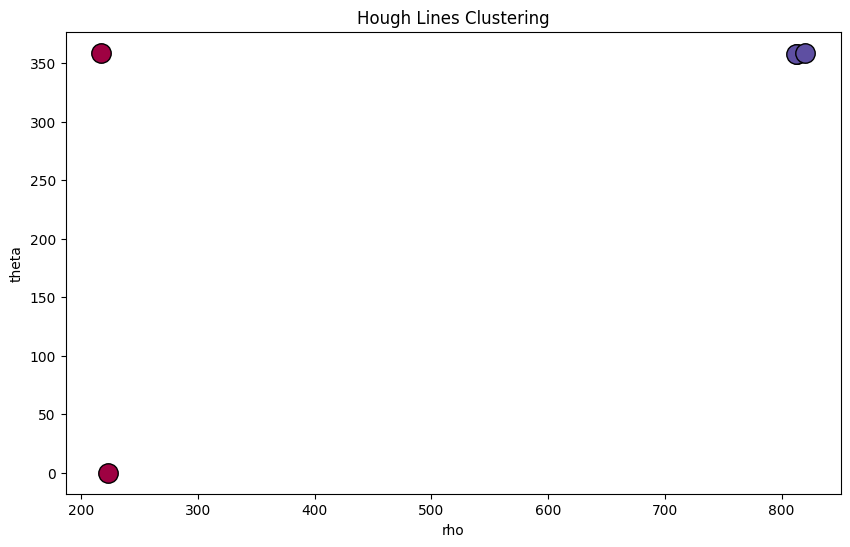

In [31]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# 주어진 (rho, theta) 리스트
lines = [
    (217.000, 359.000),
    (813.532, 358.000),
    (223.000, 0.000),
    (812.598, 358.000),
    (820.407, 359.000)
]

# 데이터를 numpy 배열로 변환
data = np.array(lines)

# theta 값을 라디안으로 변환하고, 이를 사인 및 코사인 값으로 변환
rho = data[:, 0]
theta_deg = data[:, 1]
theta_rad = np.deg2rad(theta_deg)

# 사인 및 코사인 값 계산
sin_theta = np.sin(theta_rad)
cos_theta = np.cos(theta_rad)

# 새로운 데이터셋 (rho, sin(theta), cos(theta))
transformed_data = np.column_stack((rho, sin_theta, cos_theta))

# DBSCAN 클러스터링
dbscan = DBSCAN(eps=10, min_samples=2).fit(transformed_data)

# 클러스터링 결과 출력
labels = dbscan.labels_
unique_labels = set(labels)
print("Cluster Labels:", labels)
print("Unique Labels (Cluster IDs):", unique_labels)

# 시각화
plt.figure(figsize=(10, 6))
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # 노이즈를 회색으로 표시
        col = [0, 0, 0, 1]
    
    class_member_mask = (labels == k)
    
    xy = data[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

plt.xlabel('rho')
plt.ylabel('theta')
plt.title('Hough Lines Clustering')
plt.show()


In [ ]:
import cv2
import numpy as np

# 주어진 (r, c) 및 (rho, theta) 리스트
all_lines = [
    ((0, 0), (-217.0, 3.1241393)), 
    ((0, 768), (-46.0, 3.106686)), 
    ((256, 0), (223.0, 0.0)), 
    ((256, 768), (-54.0, 3.106686)), 
    ((256, 824), (-1.0, 3.1241393))
]

# 원본 이미지 생성 (예: 640x1080 크기)
image_height, image_width = 640, 1080
img = np.zeros((image_height, image_width, 3), dtype=np.uint8)

# 패치 내의 (rho, theta) 값을 원본 이미지의 좌표계로 변환하는 함수
def convert_rho_theta(r, c, rho, theta):
    theta_rad = theta  # 이미 라디안 단위로 제공된 경우
    # theta가 도 단위로 제공된 경우: theta_rad = np.deg2rad(theta)
    new_rho = rho + c * np.cos(theta_rad) + r * np.sin(theta_rad)
    if new_rho<0:  ##########################
        new_rho = -new_rho
        theta = theta+np.pi
    return new_rho, theta

# 직선 그리기 함수
def draw_lines(image, all_lines):
    for (r, c), (rho, theta) in all_lines:
        new_rho, new_theta = convert_rho_theta(r, c, rho, theta)
        a = np.cos(new_theta)
        b = np.sin(new_theta)
        x0 = a * new_rho
        y0 = b * new_rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
        print(f"Line drawn: rho={new_rho:8.3f}, theta={new_theta * 180 / np.pi:7.3f} DEG, points=(({x1},{y1}), ({x2},{y2}))")

# 직선을 이미지에 그리기
draw_lines(img, all_lines)

# 결과 이미지 보기
cv2.imshow('Hough Lines', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

Cluster Labels: [1 0 1 0 0]
Cluster Centroids: [[ 8.15512333e+02 -2.90837999e-02  9.99543116e-01]
 [ 2.20000000e+02 -8.72620322e-03  9.99923848e-01]]


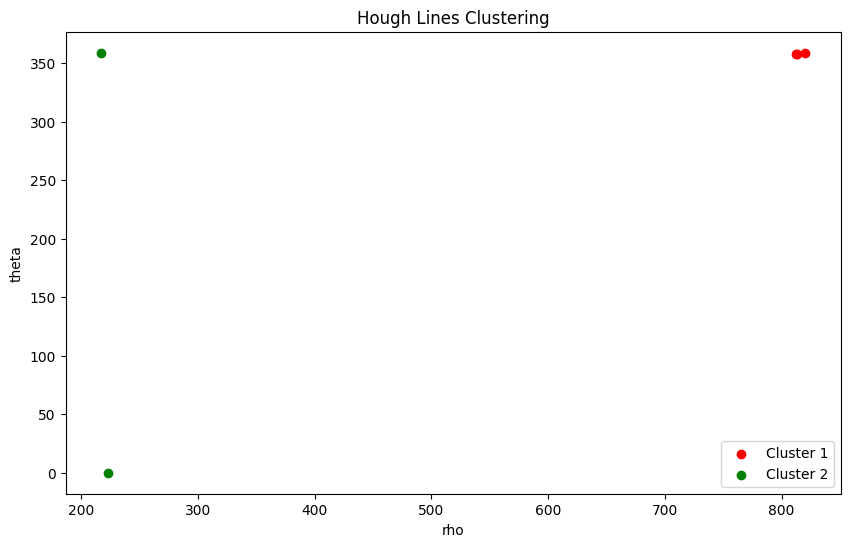

In [22]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 주어진 (rho, theta) 리스트
lines = [
    (217.000, 359.000),
    (813.532, 358.000),
    (223.000, 0.000),
    (812.598, 358.000),
    (820.407, 359.000)
]

# 데이터를 numpy 배열로 변환
data = np.array(lines)

# theta 값을 라디안으로 변환하고, 이를 사인 및 코사인 값으로 변환
rho = data[:, 0]
theta_deg = data[:, 1]
theta_rad = np.deg2rad(theta_deg)

# 사인 및 코사인 값 계산
sin_theta = np.sin(theta_rad)
cos_theta = np.cos(theta_rad)

# 새로운 데이터셋 (rho, sin(theta), cos(theta))
transformed_data = np.column_stack((rho, sin_theta, cos_theta))

# KMeans 클러스터링
num_clusters = 2  # 예제에서는 2개의 클러스터로 가정합니다. 필요에 따라 변경 가능합니다.
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=0).fit(transformed_data)

# 클러스터링 결과 출력
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

print("Cluster Labels:", labels)
print("Cluster Centroids:", centroids)

# 시각화
plt.figure(figsize=(10, 6))
colors = ['r', 'g', 'b', 'c', 'm']

for i in range(num_clusters):
    cluster_points = data[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[i], label=f'Cluster {i+1}')

plt.xlabel('rho')
plt.ylabel('theta')
plt.legend()
plt.title('Hough Lines Clustering')
plt.show()


In [ ]:
im2patch = Image2Patches(image_size = (1080,640), patch_size=(256, 256))
line_detector = LineDetector(mask_thres = 0.7, hough_min_length=50)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet(pretrained=True).to(device)
model.load_state_dict(torch.load('best_params_0011.pt'))


padding = 16
all_lines = []
for idx, ((patch, (i, j)), (mask, (m, n))) in enumerate(zip(patches, predictions)):
    mask_img = mask[padding:-padding, padding:-padding]  # Remove mask padding
    lines, src_image = line_detector(patch, mask_img)
    max_element = select_bestline(lines, src_image, mask_img)
    if max_element:
        res_im_max, psum_max, all_line_pixels, (rho,theta) = max_element
        all_lines.append((all_line_pixels, (i,j)))
        print(f"{idx}: Maximum psum: {psum_max}, num_pixels: {len(all_line_pixels)}, hough: ({rho},{theta})")

In [ ]:
def show_tensor_image(tensor_image):
    # Convert the tensor to a NumPy array
    np_image = tensor_image.numpy()

    # Transpose the image to (256, 256, 3) from (3, 256, 256)
    np_image = np.transpose(np_image, (1, 2, 0))
    
    # Normalize the image to range [0, 1] if necessary
    np_image = (np_image - np_image.min()) / (np_image.max() - np_image.min())
    
    # Display the image
    plt.imshow(np_image)
    plt.axis('off')  # Turn off axis
    plt.show()

In [ ]:
padding = 16
for (patch, (i, j)), (mask, (m, n)) in zip(patches, predictions):
    # Remove padding
    patch_img = patch[:, padding:-padding, padding:-padding]
    mask_img = mask[padding:-padding, padding:-padding]
    
    # Show the patch image
    plt.figure()
    plt.subplot(1, 2, 1)
    show_tensor_image(patch_img)
    
    # Show the mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask_img)  # Convert mask to HWC format
    #plt.title(f"Prediction: {prediction}")
    plt.axis('off')
    
    plt.show()
#    break